# Cloning Repo & installing libs

In [144]:
page=1
content = """"""

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Setting paths

In [146]:
# countries           = [ 'South Korea', 'Cuba', 'India', 'Pakistan', 'Bangladesh','China']#, 'Turkey']
countries         = [ 'South Korea','Argentina']
# countries           = ['Saudi Arabia','South Korea','India','China', 'Pakistan', 'Bangladesh', 'Argentina', 'Botswana']
states            = ['Andhra Pradesh','Maharashtra','Gujarat','Tamil Nadu','Puduchery']
primary           = "20-24-Primary_fin"
lower_secondary   = "20-24-Lower_Secondary_fin"
higher_secondary  = "20-24-Higher_Secondary_fin"
college           = "25-29-College_comp"
life_expectancy   = "life_expectancy"
gdp_per_capita    = "gdp_per_capita"
total_fertility   = "children_per_woman"
india_tfr         = "india_tfr"
dpi               = 500 #image quality

In [147]:
def load_paths():
  root = "./edu_datasets/" 
  
  global datasets_path  
  datasets_path = {
                      "20-24-Primary_fin"               :  root+ "20-24-Primary_fin.csv",
                      "20-24-Lower_Secondary_fin"       :  root+ "20-24-Lower_Secondary_fin.csv",
                      "20-24-Higher_Secondary_fin"      :  root+ "20-24-Higher_Secondary_fin.csv",
                      "25-29-College_comp"              :  root+ "College_comp.csv",
                      "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                      "gdp_per_capita"                  :  root+ "gdppercapita_us_inflation_adjusted.csv",
                      "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                      "india_tfr"                       :  root+ "India/TFR.csv",    
                  }
  return datasets_path


In [148]:
def generate_csv(edu_level,countries,index):
    datasets_path   = load_paths()
    df = pd.read_csv(datasets_path[edu_level])
    # get the countries
    df = df[df['Country'].isin(countries)]
    # transpose the dataframe with country as index and years as columns
    df = df.set_index('Country').T
    df = df.reset_index()
    df = df.rename(columns={'index':'Year'})
    df = df.rename_axis(None, axis=1)
    
    path = f'./graphs/{page}/{index}.csv'
    df.to_csv(path, index=False)
    return path
    
    

In [149]:
edu_level           = primary
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
print(generate_csv(edu_level,countries,'1'))

./graphs/1/1.csv


In [150]:

def build_graph(ylabel,file_name,page):
  datasets_path   = load_paths()
  if toggle:
    finish_dic      = create_n_fin_dic()
    country_coords  = find_coords(finish_dic)
    plot_graph(ylabel, country_coords,file_name,finish_dic)
    rewrite_js_file()
  else:
    country_coords  = find_coords_yearly()
    plot_graph(ylabel, country_coords,file_name)



In [151]:
def create_n_fin_dic():
  df = pd.read_csv(datasets_path[edu_level])
  df = df[df['Country'].isin(countries)]
  end_year = 2016
  if edu_level == gdp_per_capita or edu_level == life_expectancy:
    end_year = 2021
  years = list(range(1960, end_year))
  period_dic = {country : [] for country in countries}
  for i in range(len(df)):
    started = False
    s_year  = 1960
    for year in years:
      if not started and df.iloc[i][str(year)] >= initial_comp_rate and df.iloc[i][str(year)] < final_comp_rate:
        started = True
        s_year  = year
        period_dic[df.iloc[i]['Country']].append(year)
      elif started and df.iloc[i][str(year)] >= final_comp_rate :
        period_dic[df.iloc[i]['Country']].append(year)
        break
    else:
      if started:
        period_dic[df.iloc[i]['Country']].append(year)

  return period_dic

In [152]:
def find_coords(fin_dic):
  
  df = pd.read_csv(datasets_path[edu_level])
  country_coords = {}
  for country in countries:
    if len(fin_dic[country])==2:
      s_y,e_y = fin_dic[country]
    else:
      s_y,e_y = 0,-1
    x_coords= [i for i in range(e_y-s_y+1)]
    y_coords= []
    df_c = df[df.Country==country]               
    for y in range(s_y,e_y+1):
      y_coords.append(df_c[str(y)].tolist())
    y_coords = [j for sub in y_coords for j in sub]
    if edu_level==gdp_per_capita:
      y_coords = np.log10(y_coords)
    country_coords[country] = [x_coords,y_coords]

  return country_coords

In [153]:
def find_coords_yearly():
  
  df = pd.read_csv(datasets_path[edu_level])

  country_coords = {}
  s_y,e_y=1960,2020 if edu_level == gdp_per_capita or edu_level == life_expectancy else 2015
  for country in countries:
    x_coords= [i for i in range(s_y,e_y+1)]
    y_coords= []
    df_c = df[df.Country==country]               
    for y in range(s_y,e_y+1):
      y_coords.append(df_c[str(y)].tolist())
    y_coords = [j for sub in y_coords for j in sub]
    if edu_level==gdp_per_capita:
      y_coords = np.log10(y_coords)
    country_coords[country] = [x_coords,y_coords]

  return country_coords

In [154]:
def plot_graph(ylabel, country_coords,file_name,finish_dic={}):
  for country,coords in country_coords.items():
    try:
      # print(f"{country:<20}{finish_dic[country]}")
      pass
    except:
      pass
    plt.plot(coords[0], coords[1],label=country)
  plt.ylabel(ylabel)
  if edu_level == gdp_per_capita:
    locs, labels = plt.yticks()
    labels = [round(10**float(item),2) for item in locs]
    plt.yticks(locs, labels)
  plt.legend()
  plt.tight_layout()
  try:
    os.mkdir(f"graphs/{page}")
  except:
    pass
  plt.savefig(f'./graphs/{page}/{file_name}.png', dpi=dpi)
  # plt.show()
  


In [155]:
import os
from string import Template
def rewrite_js_file():
    file_names = [i for i in os.listdir('./graphs') if i.endswith('.png')]
    
    file_names.sort()
    try:
      os.mkdir(f"js/{page}")
    except:
      pass
    with open(f'./js/{page}/displayGraph.js','w') as f:
      f.write(f"var file_names = {file_names};")
      f.write("\n")
      f.write("""document.addEventListener('DOMContentLoaded', function() {

    for (var i = 0; i < file_names.length; i++) {
        var img = document.createElement("img");
        img.src = "graphs/"""+str(page)+"""/"+file_names[i];
        img.alt = file_names[i];
        img.className = 'centerImg'
        document.body.appendChild(img);
    }

     
}
);""")

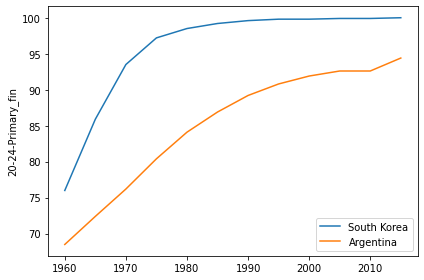

In [156]:
edu_level           = primary
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
generate_csv(edu_level,countries,'1')
build_graph(edu_level,'1',page)

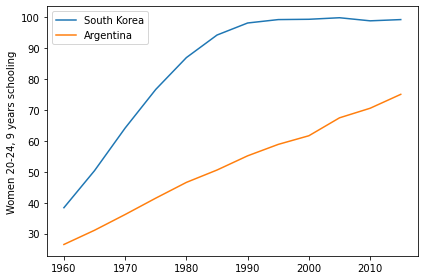

In [157]:
edu_level           = lower_secondary
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
generate_csv(edu_level,countries,'2')
build_graph('Women 20-24, 9 years schooling','2',page)

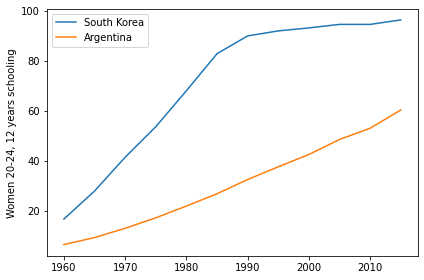

In [158]:

edu_level           = higher_secondary
initial_comp_rate   = 40
final_comp_rate     = 100
toggle              = False
generate_csv(edu_level,countries,'3')
build_graph('Women 20-24, 12 years schooling','3',page)

In [159]:
# edu_level           = life_expectancy
# initial_comp_rate   = 10
# final_comp_rate     = 90

# toggle              = True
# build_graph('Life Expectancy','4')


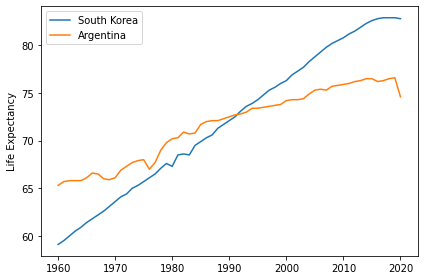

In [160]:
initial_comp_rate   = 10
final_comp_rate     = 90
edu_level           = life_expectancy
toggle              = False
generate_csv(edu_level,countries,'5')
build_graph('Life Expectancy','5',page)

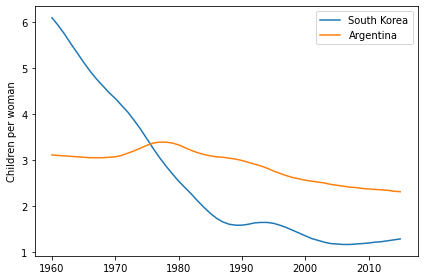

In [161]:
edu_level           = total_fertility
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
generate_csv(edu_level,countries,'6')
build_graph('Children per woman','6',page)

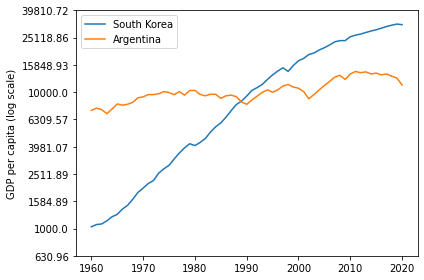

In [162]:
edu_level           = gdp_per_capita
initial_comp_rate   = 00
final_comp_rate     = 9999999
toggle              = False
generate_csv(edu_level,countries,'7')
build_graph('GDP per capita (log scale)','7',page)

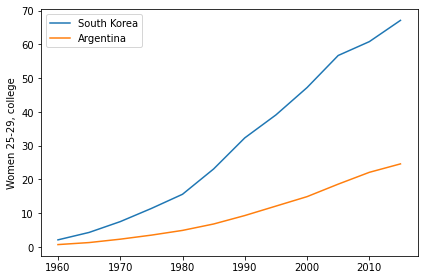

In [163]:
edu_level           = college
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
generate_csv(edu_level,countries,'8')
build_graph('Women 25-29, college','8',page)

,1981,1991,1999,2009,2017,2020,2021
State,,,,,,,
Puduchery,NaN,NaN,1.8,1.6,1.6,1.6,NaN
Andhra Pradesh,4.0,3.0,2.4,1.8,1.8,1.7,1.7
Maharashtra,3.6,3.0,2.7,1.9,1.7,1.7,1.7
Tamil Nadu,3.4,2.2,2.0,1.7,1.6,1.6,1.8
Gujarat,4.3,3.1,3.0,2.5,2.2,1.9,1.9


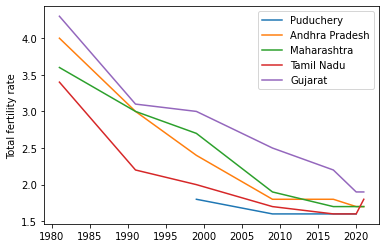

In [164]:
load_paths()
india_df = pd.read_csv(datasets_path[india_tfr])
india_df = india_df[india_df['State'].isin(states)]
india_df.set_index("State",inplace=True)
display(india_df)
col_years = list(map(int, india_df.columns[:]))
state_coords = {}
for ind in india_df.index:
    value = [col_years]
    value.append(india_df.loc[ind].values.flatten().tolist())
    state_coords[ind] = value
for state,coords in state_coords.items():
    plt.plot(coords[0], coords[1],label=state)

plt.ylabel('Total fertility rate')
plt.legend()
# plt.savefig(f'./graphs/{page}/9.png', dpi=dpi)

In [165]:
import subprocess
page+=1
if(page>10):
    page = 1
subprocess.call(["git", "add", '.'])
subprocess.call(["git","commit","-m",'"added graphes"'])
subprocess.call(["git", "push"])

0